<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/MergeDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO-DO: filter before merging**

##Loading Files

In [0]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

In [0]:
url = 'https://www.dati.lombardia.it/api/views/bbky-sde5/rows.csv?accessType=DOWNLOAD'

if os.path.isdir('/tmp'):
    if os.path.isfile('/tmp/cened20.csv'):
      pass
    else:
      urllib.request.urlretrieve(url, '/tmp/cened20.csv')
else:
  os.mkdir('/tmp')
  urllib.request.urlretrieve(url, '/tmp/cened20.csv')

In [0]:
url = 'https://www.dati.lombardia.it/api/views/rsg3-xhvk/rows.csv?accessType=DOWNLOAD'


if os.path.isfile('/tmp/cened12.csv'):
  pass
else:
  urllib.request.urlretrieve(url, '/tmp/cened12.csv')


In [0]:
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [701]:
cols20 = ['COMUNE','FOGLIO', 'PARTICELLA','SUPERFICIE_DISPERDENTE', 'EP_H_ND',
        'RIQUALIFICAZIONE_ENERGETICA','RISTRUTTURAZIONE_IMPORTANTE', 
        'INTERO_EDIFICIO','SUPERF_UTILE_RISCALDATA','EP_GL_NREN','EP_GL_REN']

cols12 = ['COMUNE','FOGLIO', 'PARTICELLA','SUPERFICIE_DISPERDENTE',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO', 'DESTINAZIONE_DI_USO',
          'ANNO_COSTRUZIONE','SUPERFICIE_VETRATA_OPACA', 'VOLUME_NETTO',
          'SUPERFICIE_NETTA', 'EPH']
  
cened20 = pd.read_csv('/tmp/cened20.csv', usecols = cols20)
cened12 = pd.read_csv('/tmp/cened12.csv', usecols = cols12)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pre-filtering

In [0]:
cened20['EP_GL_NREN'].fillna(0, inplace=True)
cened20['EP_GL_REN'].fillna(0, inplace=True)

# Drop NaN 
cened20 = cened20.dropna()
cened12 = cened12.dropna() 

In [0]:
# Only entire buildings
cened20 = cened20[cened20['INTERO_EDIFICIO'] == True]

In [0]:
# Drop renovations
cened20 = cened20[cened20['RISTRUTTURAZIONE_IMPORTANTE'] == False]
cened20 = cened20[cened20['RIQUALIFICAZIONE_ENERGETICA'] == False]

## Merge

In [0]:
# Merge dfs
cenedtot = pd.merge(left=cened20, right=cened12, left_on=['COMUNE','FOGLIO', 'PARTICELLA'], 
                    right_on=['COMUNE','FOGLIO', 'PARTICELLA'],  how='inner') # , 'SUBALTERNO' | , 'SUBALTERNO'

In [0]:
# Compute difference between ext surfaces
cenedtot['surfdiff'] = abs((cenedtot['SUPERF_UTILE_RISCALDATA'] - cenedtot['SUPERFICIE_NETTA'])/cenedtot['SUPERF_UTILE_RISCALDATA'])

# Drop rows with high difference
cenedtot = cenedtot[cenedtot['surfdiff'] < 0.2]

# Compute difference between ext surfaces
#cenedtot['surfdiff'] = abs((cenedtot['SUPERFICIE_DISPERDENTE_y'] - cenedtot['SUPERFICIE_DISPERDENTE_x'])/cenedtot['SUPERFICIE_DISPERDENTE_y'])

# Drop rows with high difference
#cenedtot = cenedtot[cenedtot['surfdiff'] < 0.05]



In [0]:
# Compute difference between ext surfaces
cenedtot['ephdiff'] = abs((cenedtot['EPH'] - cenedtot['EP_H_ND'])/cenedtot['EPH'])

# Drop rows with high difference
cenedtot = cenedtot[cenedtot['ephdiff'] < 0.3]

In [0]:
cenedtot = cenedtot.dropna() 

##Feature Creation

In [0]:
# Add ddh
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.lower()
ddh['comune'] = ddh['comune'].str.lower()
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.replace(r"o`",  "o'")
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.replace(r"baranzate",  "bollate")
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cenedtot['COMUNE'] = cenedtot['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cenedtot = cenedtot.merge(ddh, left_on='COMUNE', right_on='comune', how='left')

In [0]:
cenedtot.ANNO_COSTRUZIONE = cenedtot.ANNO_COSTRUZIONE.astype(str)
cenedtot.ANNO_COSTRUZIONE = cenedtot.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cenedtot.ANNO_COSTRUZIONE = cenedtot.ANNO_COSTRUZIONE.astype(int)

cenedtot['PERIODO'] = pd.cut(cenedtot.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

In [0]:
# Opaque surface
cenedtot['SUP_OPACA'] = cenedtot['SUPERFICIE_DISPERDENTE_y']/(1+cenedtot['SUPERFICIE_VETRATA_OPACA'])

# Opaque surface
cenedtot['SUP_FINESTRATA'] = cenedtot['SUPERFICIE_DISPERDENTE_y'] - cenedtot['SUP_OPACA']

In [0]:
cenedtot['ALTEZZA_MEDIA'] = cenedtot['VOLUME_NETTO']/cenedtot['SUPERFICIE_NETTA']

In [0]:
cenedtot['TRASMITTANZA_MEDIA'] = (cenedtot['TRASMITTANZA_MEDIA_SERRAMENTO'] + cenedtot['TRASMITTANZA_MEDIA_COPERTURA'] +
         cenedtot['TRASMITTANZA_MEDIA_BASAMENTO'] + cenedtot['TRASMITTANZA_MEDIA_INVOLUCRO'])/4

In [0]:
cenedtot['EP_GL_TOT'] = cenedtot['EP_GL_REN'] + cenedtot['EP_GL_NREN']

##Filters

In [0]:
for col in ['TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO']:
          cenedtot = cenedtot[cenedtot[col].between(0,6, inclusive=False)]

In [0]:
# Drop buildings with wrong An
cenedtot = cenedtot[cenedtot['SUPERFICIE_NETTA'] > 50]

# Drop buildings with wrong Vn
cenedtot = cenedtot[cenedtot['VOLUME_NETTO'] > 150]

In [0]:
cenedtot = cenedtot[cenedtot['DESTINAZIONE_DI_USO'] == 'E.1(1)']

In [0]:
cenedtot = cenedtot[cenedtot['TRASMITTANZA_MEDIA'] > 0.15]
cenedtot = cenedtot[cenedtot['TRASMITTANZA_MEDIA'] < 4]

In [0]:
cenedtot = cenedtot[cenedtot['ALTEZZA_MEDIA'] > 2.4]
cenedtot = cenedtot[cenedtot['ALTEZZA_MEDIA'] < 6]

In [0]:
# Drop buildings with wrong EPH
# cenedtot = cenedtot[cenedtot['EP_H_ND'] > 120]
cenedtot = cenedtot[cenedtot['EP_H_ND'] < 1000]

In [721]:
len(cenedtot)

957

##ML

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
def split_db(X, y, split = [.8,.1], seed = 0):
    s = [x for x in range(len(y))]
    random.Random(seed).shuffle(s)
    X = X[s]
    y = y[s]
    split1 = int(len(X)*split[0])
    split2 = split1 + int(len(X)*split[1])
    X_train = X[:split1]
    y_train = y[:split1]
    X_val = X[split1:split2]
    y_val = y[split1:split2]
    X_test = X[split2:]
    y_test = y[split2:]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
mlcol = ['SUPERFICIE_DISPERDENTE_y', 'SUPERFICIE_NETTA', 'VOLUME_NETTO',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO','dd','PERIODO','SUP_OPACA',
        'SUP_FINESTRATA']

X = cenedtot[mlcol]

In [0]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [0]:
y = cenedtot.EP_H_ND.values #EP_H_ND!!
X_train, X_val, X_test, y_train, y_val, y_test = split_db(X, y, split = [.8,.1], seed = 42)

In [0]:
K.clear_session()

In [0]:
from keras.constraints import max_norm

# Create NN
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X.shape[1], activation='relu'),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)), #, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)
        tf.keras.layers.Dense(1, activation='linear')
        ])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), loss = 'mape', metrics=[r2, 'mape', 'mse'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 9000, batch_size = 256, verbose=0) #,use_multiprocessing = True

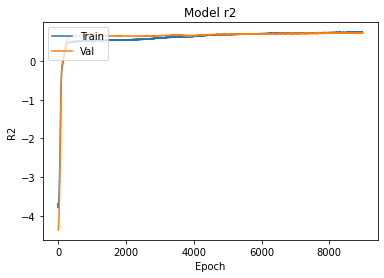

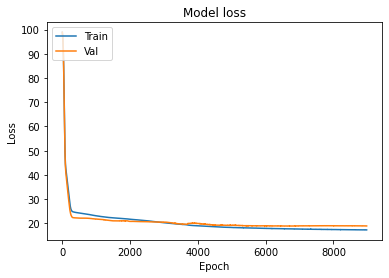

In [730]:
# Plot training & validation accuracy values
plt.plot(history.history['r2'][20:])
plt.plot(history.history['val_r2'][20:])
plt.title('Model r2')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

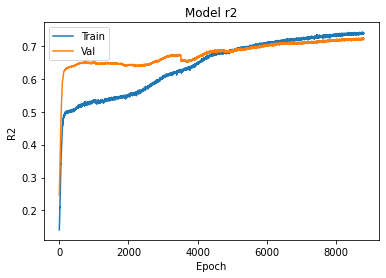

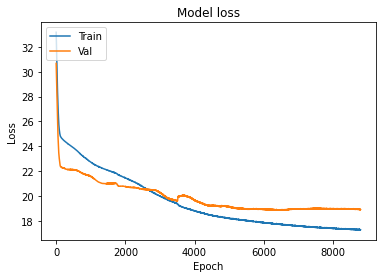

In [731]:
# Plot training & validation accuracy values
plt.plot(history.history['r2'][200:])
plt.plot(history.history['val_r2'][200:])
plt.title('Model r2')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][200:])
plt.plot(history.history['val_loss'][200:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()